# **Solving the Gym Bowling Environnement using an Actor-Critic agent**

Adam Aboucaya and Remi Vialleton made this notebook for the Reinforcement Learning course at the University of Stavanger during the first semester of 2024-2025. 

## **Introduction**

## **Setup and imports**

In [33]:
""" %pip install gymnasium ale-py
%pip install gymnasium[atari]
%pip install gymnasium[accept-rom-license] """

' %pip install gymnasium ale-py\n%pip install gymnasium[atari]\n%pip install gymnasium[accept-rom-license] '

In [34]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import ale_py
from collections import deque
import matplotlib.pyplot as plt
import random
from torch.optim.lr_scheduler import StepLR
import os

In [35]:
ENV_NAME = 'ALE/Bowling-v5'
RANDOM_STATE = 10
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

## **Environment Exploration**

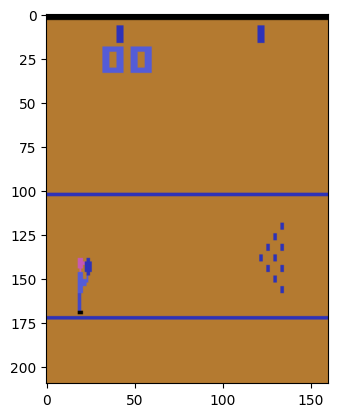

In [36]:
env = gym.make(ENV_NAME, render_mode='rgb_array')
env.reset()
obs = env.render()
plt.imshow(obs)

(65, 160, 3)


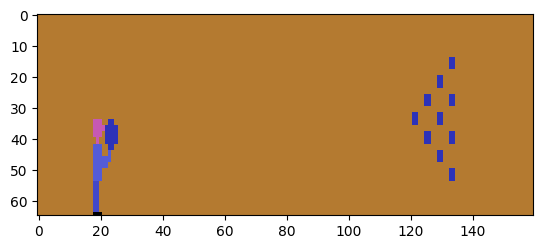

In [37]:
vertical_crop_start   = 105   
vertical_crop_end     = 170       
horizontal_crop_start = 0         
horizontal_crop_end   = 160

cropped_obs = obs[vertical_crop_start:vertical_crop_end, horizontal_crop_start:horizontal_crop_end]
print(cropped_obs.shape)
plt.imshow(cropped_obs)

In [38]:
class RemoveScoreBoard(gym.ObservationWrapper):
  
    def __init__(self, env):
        super().__init__(env)
    
    def observation(self, obs):
        return obs[vertical_crop_start:vertical_crop_end,\
                   horizontal_crop_start:horizontal_crop_end]
    
observation_space_shape = cropped_obs.shape

## **Overview of the Actor-Critic Model**

In [39]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.clamp(x, -10, 10)
        return torch.softmax(self.fc4(x), dim=-1)

In [40]:
class Critic(nn.Module):
    def __init__(self, state_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)


## **Strategy Used**

## **Model Architecture**

## **Defining Variables**

## **Training Method**

In [ ]:
class A2CAgent:
    def __init__(self, env):
        self.env = env
        self.env.seed = torch.seed
        self.state_size = np.prod(observation_space_shape)
        self.action_size = env.action_space.n
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.actor = Actor(self.state_size, self.action_size).to(self.device)
        self.critic = Critic(self.state_size).to(self.device)

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0001)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.0001)

        # Learning rate schedulers
        self.actor_scheduler = StepLR(self.actor_optimizer, step_size=50, gamma=0.9)
        self.critic_scheduler = StepLR(self.critic_optimizer, step_size=50, gamma=0.9)

        # Exploration and other parameters (optimal : epsilon = 0.45, epsilon_decay=0.96, lr = 0.0001, gamma = 0.97)
        self.gamma = 0.97
        self.epsilon = 0.35 # Initial exploration
        self.epsilon_decay = 0.97
        
        # Decay rate of exploration
        self.epsilon_min = 0.01  # Minimum exploration

        # Sliding window for tracking the last 10 scores
        self.scores_window = deque(maxlen=10)
        
        # Directory for saving models
        self.save_dir = './saved_models'
        os.makedirs(self.save_dir, exist_ok=True)

    def save_model(self, epoch, mean_score):
        """Saves both the actor and critic models to the specified directory."""
        model_path = os.path.join(self.save_dir, f"actor_critic_epoch_{epoch}_mean_score_{mean_score:.2f}.pth")
        print(f"Saving model to {model_path}")
        torch.save({
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
            'epoch': epoch,
            'mean_score': mean_score
        }, model_path)
        
    def load_model(self, model_path):
        """Charge les poids de l'actor et du critic depuis le fichier sauvegardé."""
        map_location = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint = torch.load(model_path, map_location=map_location)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        # Optionnel : si vous voulez reprendre l'entraînement, vous pouvez aussi charger les optimizers
        self.actor_optimizer.load_state_dict(checkpoint['actor_optimizer_state_dict'])
        self.critic_optimizer.load_state_dict(checkpoint['critic_optimizer_state_dict'])
        print(f"Model loaded from {model_path}")

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)  # Random action for exploration
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        probs = self.actor(state).detach().cpu().numpy()[0]
        action = np.random.choice(self.action_size, p=probs)
        return action

    def train(self, epochs=200, max_moves=5000, batch_size=128, render=False):
        scores = []
        info = {
            "epochs": [],
            "scores": [],
            "actor_loss": [],
            "critic_loss": []
        }
        buffer = deque(maxlen=1000)  # Buffer for storing transitions
        for e in range(epochs):
            state, _ = self.env.reset()
            state = state.flatten()
            done = False
            score = 0
            max_moves_remaining = max_moves

            while not done and max_moves_remaining > 0:

                max_moves_remaining -= 1
                action = self.get_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_state = next_state.flatten()

                # Store the experience in the buffer
                buffer.append((state, action, reward, next_state, done))

                state = next_state
                score += reward

            # Update by batch
            if len(buffer) >= batch_size:
                transitions = random.sample(buffer, batch_size)
                states, actions, rewards, next_states, dones = zip(*transitions)
                states_tensor = torch.from_numpy(np.array(states)).float().to(self.device)
                next_states_tensor = torch.from_numpy(np.array(next_states)).float().to(self.device)
                actions_tensor = torch.tensor(actions, dtype=torch.long).to(self.device)
                rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(self.device)
                dones_tensor = torch.tensor(dones, dtype=torch.float32).to(self.device)

                # Calculate values and advantages
                values = self.critic(states_tensor)
                next_values = self.critic(next_states_tensor).detach()
                advantages = rewards_tensor + self.gamma * next_values * (1 - dones_tensor) - values

                probs = self.actor(states_tensor)
                log_probs = torch.log(probs[range(batch_size), actions_tensor])
                actor_loss = -(log_probs * advantages.detach()).mean()

                # Calculate critic loss
                critic_loss = (advantages.pow(2)).mean()

                # Update actor and critic with gradient clipping
                self.actor_optimizer.zero_grad()
                actor_loss.backward()
                self.actor_optimizer.step()

                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

            # Decay epsilon to reduce exploration
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Add score to the sliding window and calculate the mean
            self.scores_window.append(score)
            mean_score = np.mean(self.scores_window)

            scores.append(score)
            info["epochs"].append(e)
            info["scores"].append(scores[e])
            info["actor_loss"].append(actor_loss.item())
            info["critic_loss"].append(critic_loss.item())
            print(f'Epoch: {e+1}/{epochs}, Score: {score}, Mean Score (Last 10): {mean_score:.2f}, Actor Loss: {actor_loss.item()}, Critic Loss: {critic_loss.item()}')

            # Check if the stopping condition is met (mean_score >= 75)
            if mean_score >= 75:
                self.save_model(e, mean_score)
                break

            # Step the schedulers to update the learning rate
            self.actor_scheduler.step()
            self.critic_scheduler.step()

        return info

    def test(self, episodes=10, max_moves=5000, render=True):
        for e in range(episodes):
            state, _ = self.env.reset()
            state = state.flatten()
            done = False
            score = 0
            max_moves_remaining = max_moves
            while not done and max_moves_remaining > 0:
                if render:
                    self.env.render()
                max_moves_remaining -= 1
                action = self.get_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                next_state = next_state.flatten()
                score += reward
                state = next_state
            print(f'Test Episode: {e+1}/{episodes}, Score: {score}')


    def plot(self, info_):
        # Sort the scores by epoch
        #info_.sort(axis=1)
        # Extract the epochs and respective scores
        epochs, scores, actor_loss, critic_loss = info_["epochs"], info_["scores"], info_["actor_loss"], info_["critic_loss"]

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

        ax1.plot(epochs, scores)
        ax1.set_title('Scores')
        ax1.set_xlabel('episode')
        ax1.set_ylabel('score')

        ax2.plot(epochs, actor_loss)
        ax2.set_title('Actor Loss')
        ax2.set_xlabel('episode')
        ax2.set_ylabel('loss')

        ax3.plot(epochs, critic_loss)
        ax3.set_title('Critic Loss')
        ax3.set_xlabel('episode')
        ax3.set_ylabel('loss')

        plt.show()

In [ ]:
env = gym.make(ENV_NAME)
env = RemoveScoreBoard(env)
agent = A2CAgent(env)
print("Training the agent...")
info = agent.train(epochs=1000, render=False)

agent.plot(info)

Training the agent...
Epoch: 1/1000, Score: 31.0, Mean Score (Last 10): 31.00, Actor Loss: 0.7392889857292175, Critic Loss: 0.29807955026626587
Epoch: 2/1000, Score: 30.0, Mean Score (Last 10): 30.50, Actor Loss: 0.511406660079956, Critic Loss: 0.46351003646850586
Epoch: 3/1000, Score: 21.0, Mean Score (Last 10): 27.33, Actor Loss: -1.9245857000350952, Critic Loss: 6.24648904800415
Epoch: 4/1000, Score: 25.0, Mean Score (Last 10): 26.75, Actor Loss: 0.16866648197174072, Critic Loss: 0.306784987449646
Epoch: 5/1000, Score: 28.0, Mean Score (Last 10): 27.00, Actor Loss: 0.6034197807312012, Critic Loss: 0.1429198831319809
Epoch: 6/1000, Score: 39.0, Mean Score (Last 10): 29.00, Actor Loss: 0.3571276366710663, Critic Loss: 0.3472941517829895
Epoch: 7/1000, Score: 29.0, Mean Score (Last 10): 29.00, Actor Loss: -0.32850074768066406, Critic Loss: 0.06174492835998535
Epoch: 8/1000, Score: 35.0, Mean Score (Last 10): 29.75, Actor Loss: -0.40558022260665894, Critic Loss: 0.13929274678230286
Epoc

## **Evaluation**

In [ ]:
# Après l'entraînement ou lors du test
model_path = "./saved_models/actor_critic_epoch_75_mean_score_75.60.pth"  # Chemin vers votre modèle sauvegardé
agent.load_model(model_path)

# Ensuite, vous pouvez tester l'agent sur de nouvelles parties
print("Testing the agent...")
agent.env = gym.make(ENV_NAME, render_mode="human")
agent.test(episodes=20, render=True)

C:\Users\rem3D\AppData\Local\Temp\ipykernel_24620\1229979987.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=map_locati

RuntimeError: Error(s) in loading state_dict for Actor:
	size mismatch for fc1.weight: copying a param with shape torch.Size([256, 100800]) from checkpoint, the shape in current model is torch.Size([256, 31200]).

## **Results and Analysis**

## **Challenges and Improvements**

## **Conclusion**